In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
from torchvision.models import vgg16
from HSI_class import HSI
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import zeroPadding
import torch
import numpy as np
import random
import os
import time
import json
from datetime import datetime

start_time = time.time()

# Check if GPU is available
print("GPU Available:", torch.cuda.is_available())

# If available, print the GPU name
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))

seeded_run = True

sample_per_class = 5
num_per_category_augment_1 = 10
num_per_category_augment_2 = 10
epochs = 200

batch_size = 20
test_size = 0.5

random_indices = 0

GPU Available: True
GPU Name: NVIDIA GeForce GTX 1650


In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # PyTorch determinism
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    os.environ['PYTHONHASHSEED'] = str(seed)

if seeded_run:
    set_seed(42)
    print("seed has been set")

seed has been set


In [3]:
dataset_path = r"C:\Users\Asus TUF\Documents\code\TA\Hyperspectral oil spill detection datasets"

datasets = []

i = 0
for filename in os.listdir(dataset_path):
    if i>1:
        break
    file_path = os.path.join(dataset_path, filename)
    if os.path.isfile(file_path):  # Check if it's a file
        print(f"Processing file: {file_path}")
        hsi = HSI(file_path)
        datasets.append(hsi)
    i += 1

Processing file: C:\Users\Asus TUF\Documents\code\TA\Hyperspectral oil spill detection datasets\GM01.mat
Processing file: C:\Users\Asus TUF\Documents\code\TA\Hyperspectral oil spill detection datasets\GM02.mat


In [4]:
def testWithDataset(n): 
    hsi_test = datasets[n]

    test_img = hsi_test.img
    test_gt = hsi_test.gt

    patch_size = 9
    half_patch = patch_size // 2

    height = test_img.shape[0]
    width = test_img.shape[1]

    matrix=zeroPadding.zeroPadding_3D(test_img,half_patch) #add 0 in every side of the data
    print(f"img shape: {test_img.shape}")
    print(f"img shape after padding {matrix.shape}")
    print(f"number of pixel {width * height}")

    print(f"ground truth shape: {test_gt.shape}")

    indices0 = np.argwhere(test_gt == 0)
    indices1 = np.argwhere(test_gt == 1)

    print(f"indices = 0 shape: {indices0.shape}")
    print(f"indices = 1 shape: {indices1.shape}")

    num_samples = 50

    random_indices0 = indices0[np.random.choice(len(indices0), num_samples, replace=False)]
    random_indices1 = indices1[np.random.choice(len(indices1), num_samples, replace=False)]

    test_indices = np.vstack((random_indices0, random_indices1))

    print(test_indices.shape)

    return test_indices, test_gt, matrix

In [5]:
def predict_batch(model, feature_extractor, batch_input, device):
    with torch.no_grad():  # Disable gradient computation
        test_features = feature_extractor(batch_input)  # shape: (10, 128)
        test_features_np = test_features.numpy()     # convert to NumPy

    # --- Predict probabilities for class 1 ---
    positive_probs = model.predict_proba(test_features_np)[:, 1]

    # --- Convert probabilities to class labels using 0.5 threshold ---
    predicted_classes = (positive_probs >= 0.5).astype(int)


    return predicted_classes, positive_probs


In [6]:
import createSample as CS

hsi_ = datasets[0]
patch_size = 9


indices_0 = []
indices_1 = []

print(f"random: {random_indices}")
random_indices = 1
if random_indices:
    print("generating random sample")
    selected_patch_0, selected_patch_1, indices_0, indices_1 = CS.createSample(hsi_, patch_size, sample_per_class)
else:
    print("using generated indices")
    indices_0 = [(np.int64(188), np.int64(124)), (np.int64(523), np.int64(150)), (np.int64(1003), np.int64(474)), (np.int64(616), np.int64(508)), (np.int64(905), np.int64(552))]
    indices_1 = [(np.int64(106), np.int64(606)), (np.int64(297), np.int64(468)), (np.int64(926), np.int64(35)), (np.int64(536), np.int64(519)), (np.int64(508), np.int64(442))]

    selected_patch_0, selected_patch_1 = CS.getSample(hsi_, patch_size, sample_per_class, indices_0, indices_1)


i =0
half_patch = patch_size // 2


indices = indices_0 +  indices_1

# Concatenating along axis 0
x_train = np.concatenate((selected_patch_0, selected_patch_1), )

y_train = np.array([])

gt = hsi_.gt
for indice in indices:
    # print(gt[indice[0]][indice[1]])
    y_train = np.append(y_train, gt[indice[0]][indice[1]])

count = np.count_nonzero(y_train == 0)  # Count elements equal to 0
print(f'number of element equal 0 {count}')

count = np.count_nonzero(y_train == 1)  # Count elements equal to 1
print(f'number of element equal 1 {count}')



# Print shape to verify
print(f"x_train shape: {x_train.shape}")  # Expected output: (10, 9, 9, 224)
print(f"y_train shape: {y_train.shape}") 


random: 0
generating random sample
hsi shape
(1243, 684, 224)
creating 5 Randomly chosen 0 indices:
creating 5 Randomly chosen 1 indices:
indices 0 used: [(np.int64(1018), np.int64(74)), (np.int64(181), np.int64(470)), (np.int64(39), np.int64(306)), (np.int64(1178), np.int64(477)), (np.int64(444), np.int64(297))]
indices 1 used: [(np.int64(197), np.int64(268)), (np.int64(177), np.int64(379)), (np.int64(147), np.int64(187)), (np.int64(945), np.int64(596)), (np.int64(134), np.int64(127))]
number of element equal 0 5
number of element equal 1 5
x_train shape: (10, 9, 9, 224)
y_train shape: (10,)


In [7]:
i =1
half_patch = patch_size // 2
print(hsi_.img[indices_0[i][0]][indices_0[i][1]])
print(selected_patch_0[i][half_patch][half_patch])

print(hsi_.img[indices_1[i][0]][indices_1[i][1]])
print(selected_patch_1[i][half_patch][half_patch])
i =4
half_patch = patch_size // 2
print(hsi_.img[indices_0[i][0]][indices_0[i][1]])
print(selected_patch_0[i][half_patch][half_patch])

print(hsi_.img[indices_1[i][0]][indices_1[i][1]])
print(selected_patch_1[i][half_patch][half_patch])

[-237 -465  323  397  440  573  633  637  605  572  546  489  460  417
  388  364  343  316  292  266  235  210  198  160  145  122  120  107
  104   97   90   82   80   77   67   58   43   34   25   -2   10   26
   38   -2   21   27   25   20   18    1    0    8   29   20   22   19
   21    1   -7   -7   -6  -47 -161  -71   -3   -1   14   12   18   16
   23   15   19   17   18   11    8    9   -5  -27 -146 -221  -93  -98
  -34   -5    2    2    4   -4    9   12   14   11   19   21   20    3
   18   14    5   -3  -13  -22  -41  -74    0    0    0    0    0    0
    0    0 -170 -304 -105  -50  -72  -58  -22   -5    0    3    0    8
    6    5    0   11    0   12    9   10    6    9    1    7    6    7
    9   12   15    1    4    2    2   -2   -8  -17  -34  -72    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
  -60 -141    7    7    8   15    1   -2   25   23   30   43   44   32
   32   35   34   32   31   27   28   36   35   35   24   22   24   27
   23 

In [8]:
import augmentation as aug
n_category = 2
band_size = 224

data_augment1, label_augment1 = aug.Augment_data(x_train, y_train, n_category, patch_size, band_size, num_per_category_augment_1)

data_augment2, label_augment2 = aug.Augment_data2(x_train, y_train, n_category, patch_size, band_size, num_per_category_augment_2)

print(f"hasil augmentasi 1 shape: {data_augment1.shape}")
print(f"label augmentai 1 shape: {label_augment1.shape}")

print(f"hasil augmentasi 2 shape: {data_augment2.shape}")
print(f"label augmentasi 2 shape: {label_augment2.shape}")

print(label_augment1)
print(label_augment2)

# # Count occurrences of each unique element
# counts1 = np.bincount(label_augment1)

# # Print results
# for i, count in enumerate(counts1):
#     print(f"Element {i} occurs {count} times.")

# counts2 = np.bincount(label_augment2)

# # Print results
# for i, count in enumerate(counts2):
#     print(f"Element {i} occurs {count} times.")

# print(label_augment1[3])

data_augment = np.concatenate((data_augment1, data_augment2))
label_augment = np.concatenate((label_augment1, label_augment2))

print(f"hasil augmentasi gabungan untuk training: {data_augment.shape}")
print(f"label augmentasi gabungan: {label_augment.shape}")

# print(label_augment)

# Count occurrences of each unique element
counts = np.bincount(label_augment)

# Print results
for i, count in enumerate(counts):
    print(f"Element {i} occurs {count} times.")

hasil augmentasi 1 shape: (20, 9, 9, 224)
label augmentai 1 shape: (20,)
hasil augmentasi 2 shape: (20, 9, 9, 224)
label augmentasi 2 shape: (20,)
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
hasil augmentasi gabungan untuk training: (40, 9, 9, 224)
label augmentasi gabungan: (40,)
Element 0 occurs 20 times.
Element 1 occurs 20 times.


In [9]:
# import torch
# import torch.nn as nn
import torch.nn.functional as F

class ConvTo1D(nn.Module):
    def __init__(self):
        super(ConvTo1D, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=224, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # (batch_size, 128, 1, 1)
        self.flatten = nn.Flatten()               # (batch_size, 128)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.flatten(x)
        return x

feature_extractor = ConvTo1D()

In [10]:
print(data_augment.shape)
print(label_augment.shape)

x_data = data_augment 
y_labels = label_augment

x_data = torch.tensor(x_data)
x_data = x_data.to(torch.float32)
x_data = x_data.permute(0, 3, 1, 2)
print(f"X_train shape: {x_data.shape}")

feature_extractor = ConvTo1D()
with torch.no_grad():  # No gradient needed for feature extraction
    features = feature_extractor(x_data)  # (100, 128)
    features_np = features.numpy() 

    

print(features_np.shape)

(40, 9, 9, 224)
(40,)
X_train shape: torch.Size([40, 224, 9, 9])
(40, 128)


In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

X = features_np
y = y_labels
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42)

print(y_train)
print(y_val)

[0 1 0 0 0 0 1 1 0 1 0 1 1 0 1 0 0 1 0 1]
[1 1 1 0 0 1 1 0 1 0 0 0 1 1 1 0 1 0 0 1]


In [12]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np



pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(random_state=42, max_iter=1000)  # Set random_state
)
pipeline.fit(X_train, y_train)

# --- Predict probabilities for class 1 ---
positive_probs = pipeline.predict_proba(X_val)[:, 1]

# --- Convert probabilities to class labels using 0.5 threshold ---
predicted_classes = (positive_probs >= 0.5).astype(int)

# --- Display predictions with probabilities ---
for i, (pred, prob) in enumerate(zip(predicted_classes, positive_probs)):
    print(f"Sample {i}: Predicted = {pred}, Prob(class 1) = {prob:.4f}")

# --- Accuracy ---
acc = accuracy_score(y_val, predicted_classes)
print(f"Validation Accuracy: {acc:.4f}")


Sample 0: Predicted = 1, Prob(class 1) = 0.9962
Sample 1: Predicted = 1, Prob(class 1) = 0.9996
Sample 2: Predicted = 1, Prob(class 1) = 0.9784
Sample 3: Predicted = 0, Prob(class 1) = 0.0002
Sample 4: Predicted = 0, Prob(class 1) = 0.0573
Sample 5: Predicted = 1, Prob(class 1) = 0.9817
Sample 6: Predicted = 1, Prob(class 1) = 0.9990
Sample 7: Predicted = 0, Prob(class 1) = 0.0002
Sample 8: Predicted = 1, Prob(class 1) = 0.9972
Sample 9: Predicted = 0, Prob(class 1) = 0.0002
Sample 10: Predicted = 0, Prob(class 1) = 0.0727
Sample 11: Predicted = 0, Prob(class 1) = 0.0014
Sample 12: Predicted = 1, Prob(class 1) = 0.9808
Sample 13: Predicted = 1, Prob(class 1) = 0.9990
Sample 14: Predicted = 1, Prob(class 1) = 0.9398
Sample 15: Predicted = 0, Prob(class 1) = 0.0014
Sample 16: Predicted = 1, Prob(class 1) = 0.9994
Sample 17: Predicted = 0, Prob(class 1) = 0.0552
Sample 18: Predicted = 0, Prob(class 1) = 0.0167
Sample 19: Predicted = 1, Prob(class 1) = 0.9918
Validation Accuracy: 1.0000


In [13]:
def testWithWholeDataset(n): 
    hsi_test = datasets[n]

    test_img = hsi_test.img
    gt= hsi_test.gt

    patch_size = 9
    half_patch = patch_size // 2

    height = test_img.shape[0]
    width = test_img.shape[1]

    matrix=zeroPadding.zeroPadding_3D(test_img,half_patch) #add 0 in every side of the data
    print(f"img shape: {test_img.shape}")
    print(f"img shape after padding {matrix.shape}")
    print(f"number of pixel {width * height}")

    print(f"ground truth shape: {gt.shape}")

    indices0 = np.argwhere(gt == 0)
    indices1 = np.argwhere(gt == 1)

    print(f"indices = 0 shape: {indices0.shape}")
    print(f"indices = 1 shape: {indices1.shape}")

    return matrix, gt, indices0.shape, indices1.shape

In [14]:
def predict_batch_whole(model, feature_extractor, batch_input, device):
    with torch.no_grad():  # Disable gradient computation
        test_features = feature_extractor(batch_input)  # shape: (10, 128)
        test_features_np = test_features.numpy()     # convert to NumPy

    # --- Predict probabilities for class 1 ---
    positive_probs = model.predict_proba(test_features_np)[:, 1]

    # --- Convert probabilities to class labels using 0.5 threshold ---
    predicted_classes = (positive_probs >= 0.5).astype(int)


    return predicted_classes, positive_probs
   

In [15]:
from torch.utils.data import Dataset, DataLoader


class PatchDataset(Dataset):
    def __init__(self, matrix, gt, half_patch, expected_shape):
        self.matrix = matrix
        self.gt = gt
        self.half_patch = half_patch
        self.expected_shape = expected_shape
        self.size_x, self.size_y = matrix.shape[0], matrix.shape[1]
        self.valid_coords = [
            (x, y)
            for x in range(half_patch, self.size_x - half_patch)
            for y in range(half_patch, self.size_y - half_patch)
        ]

    def __len__(self):
        return len(self.valid_coords)

    def __getitem__(self, idx):
        x, y = self.valid_coords[idx]
        true_label = self.gt[x - self.half_patch, y - self.half_patch]

        selected_rows = self.matrix[x- self.half_patch:x + 2 * self.half_patch + 1 - self.half_patch, :]
        testing_patch = selected_rows[:, y - self.half_patch:y + 2 * self.half_patch + 1 - self.half_patch]

        # Verify patch size
        if testing_patch.shape != self.expected_shape:
            raise ValueError(f"Patch at ({x},{y}) has wrong shape {testing_patch.shape}")

        patch_tensor = torch.tensor(testing_patch, dtype=torch.float32)
        patch_tensor = patch_tensor.permute(2, 0, 1)  # (C, H, W)

        return patch_tensor, true_label, x, y  # Also return (x, y) for positioning later

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

scores = []
groundtruth = []
prediction = []
y_probs = []


timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
os.makedirs(f"predictions/LR/{timestamp}", exist_ok=True)
for dataset in range(len(datasets)):

    score = []
    patch_size = 9
    half_patch = patch_size // 2

    data_sampler = None
    batch_size = 64

    correct0 = 0
    correct1 = 0
    matrix = []
    gt = []
    expected_patch_shape = []
    dataset_patches = []
    data_loader = []
    patch_tensor = []
    true_label = [] 
    x = []
    y = []
    pred_matrix = []

    matrix, gt, indices_0_shape, indices_1_shape = testWithWholeDataset(dataset)
    print(indices_0_shape[0])
    print(indices_1_shape[0])

    expected_patch_shape = (2 * half_patch + 1, 2 * half_patch + 1, matrix.shape[2])
    dataset_patches = PatchDataset(matrix, gt, half_patch, expected_patch_shape)

    if seeded_run:
        g = torch.Generator()
        g.manual_seed(42)

        data_loader = DataLoader(
            dataset_patches,
            batch_size=batch_size,
            shuffle=False,  # set to True if needed
            num_workers=0,
            pin_memory=True,
            drop_last=False,
            generator=g
        )
        print("generate data loader using seed")
    else:
        data_loader = DataLoader(dataset_patches, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True, drop_last=False)




    patch_tensor, true_label, x, y = next(iter(data_loader))

    print(patch_tensor.size())
    print(true_label.size())
    print(f"data loader size: {len(data_loader)}")

    pred_matrix = np.full(gt.shape, -1, dtype=np.int32)
    correct = 0

    for input_batch, label_batch, x_batch, y_batch in tqdm(data_loader, desc="Predicting"):


        preds, confs = predict_batch_whole(pipeline, feature_extractor, input_batch, device)

        prediction.append(preds)
        y_probs.append(confs)
        
        label_batch = label_batch.numpy()
        x_batch = x_batch.numpy()
        y_batch = y_batch.numpy()

        for pred, label, x, y in zip(preds, label_batch, x_batch, y_batch):
            groundtruth.append(label)
            pred_matrix[x - half_patch, y - half_patch] = pred
            if pred == label:
                if label == 0:
                    correct0 += 1
                elif label == 1:
                    correct1 += 1
                
    correct = correct0+correct1
    print(f"correct0 = {correct0}")
    print(f"correct1 = {correct1}")
    total = gt.shape[0] * gt.shape[1]
    print(f"Score: {correct}/{total}")

    score = {
        'dataset': dataset,
        'class0_size': indices_0_shape[0],
        'class1_size': indices_1_shape[0],
        'correct_0': correct0,
        'correct_1': correct1,
        'correct_total': correct,
        'total': total
    }
    print(score)
    scores.append(score)
    # Save prediction matrix
    # timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    np.save(f"predictions/LR/{timestamp}/results {dataset} LR.npy", pred_matrix)

img shape: (1243, 684, 224)
img shape after padding (1251, 692, 224)
number of pixel 850212
ground truth shape: (1243, 684)
indices = 0 shape: (820876, 2)
indices = 1 shape: (29336, 2)
820876
29336
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 13285


Predicting: 100%|██████████| 13285/13285 [11:53<00:00, 18.62it/s]


correct0 = 786492
correct1 = 19484
Score: 805976/850212
{'dataset': 0, 'class0_size': 820876, 'class1_size': 29336, 'correct_0': 786492, 'correct_1': 19484, 'correct_total': 805976, 'total': 850212}
img shape: (1786, 699, 224)
img shape after padding (1794, 707, 224)
number of pixel 1248414
ground truth shape: (1786, 699)
indices = 0 shape: (1236269, 2)
indices = 1 shape: (12145, 2)
1236269
12145
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 19507


Predicting: 100%|██████████| 19507/19507 [16:04<00:00, 20.23it/s]

correct0 = 341322
correct1 = 12136
Score: 353458/1248414
{'dataset': 1, 'class0_size': 1236269, 'class1_size': 12145, 'correct_0': 341322, 'correct_1': 12136, 'correct_total': 353458, 'total': 1248414}


In [17]:
all_correct = 0
all_total = 0
all_correct0 = 0
all_correct1 = 0
class0_total = 0
class1_total = 0

for score in scores:
    dataset = score['dataset']
    correct0 = score['correct_0']
    correct1 = score['correct_1']
    class0_size = score['class0_size']
    class1_size = score['class1_size']
    correct = score['correct_total']
    total = score['total']
    print(f"dataset: {dataset}\t", f'{correct0}/{class0_size}\t', f'{correct1}/{class1_size}\t', f'{correct}/{total}\t')

    all_correct += correct
    all_total += total
    all_correct0 += correct0
    all_correct1 += correct1
    class0_total += class0_size
    class1_total += class1_size



print(f"total: \t\t {all_correct0}/{class0_total/2} \t {all_correct1}/{class1_total/2} \t {all_correct}/{all_total}")

print(f"acc: {all_correct/all_total}")



dataset: 0	 786492/820876	 19484/29336	 805976/850212	
dataset: 1	 341322/1236269	 12136/12145	 353458/1248414	
total: 		 1127814/1028572.5 	 31620/20740.5 	 1159434/2098626
acc: 0.5524729036998494


In [18]:

all_total_score = {
    'dataset': 'Total Dataset',
    'correct_0': all_correct0,
    'correct_1': all_correct1,
    'class0_total': class0_total,
    'class1_total': class1_total,
    'correct_total': all_correct,
    'total': all_total
}

scores.append(all_total_score)

In [19]:
groundtruths = groundtruth
groundtruth_in = []

for x in groundtruths:
    groundtruth_in.append(x)

predictions = prediction
prediction_in = []

for x in predictions:
    for y in x:
        prediction_in.append(y)


y_prob_in = []

for x in y_probs:
    for y in x:
        y_prob_in.append(y)

print(len(groundtruth_in))
print(len(prediction_in))
print(len(y_prob_in))

2098626
2098626
2098626


In [20]:
y_test = groundtruth_in
y_pred = prediction_in
correct = 0
total = 0

for x, y in zip(y_test, y_pred):
    total += 1
    if x == y:
        correct += 1

print(f'{correct}/{total}')

1159434/2098626


In [21]:
y_test_np = np.array([label.item() for label in y_test])
# Ensure labels are binary (0 and 1)
print("Unique values in y_test:", pd.Series(y_test_np).unique())

# Check if y_pred is probability (float) or hard prediction (int)
print("Sample y_pred values:", y_pred[:5])

Unique values in y_test: [0 1]
Sample y_pred values: [np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1)]


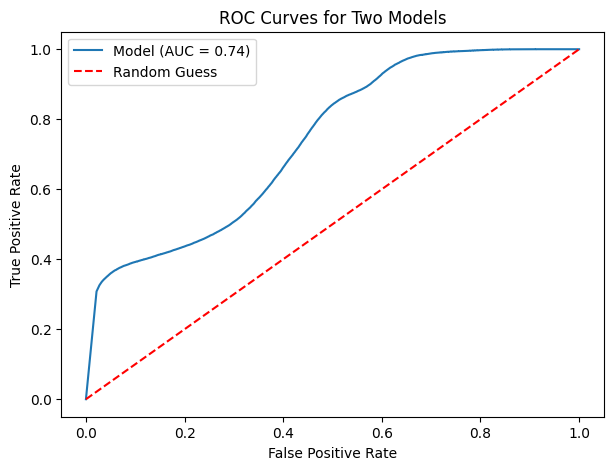

In [22]:


test_df = pd.DataFrame(
    {'True': y_test_np, 'Model': y_prob_in})

plt.figure(figsize=(7, 5))


fpr, tpr, _ = roc_curve(test_df['True'], test_df['Model'])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'Model (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Two Models')
plt.legend()
plt.show()

In [24]:


y_true = np.array([int(label) for label in y_test_np])  # true labels
y_pred = prediction_in                         # predicted class labels (e.g., from predict_batch)

# Precision, Recall, F1
precision = precision_score(y_true, y_pred, average='macro')  # Use 'binary' if binary task
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Overall Accuracy (OA)
oa = accuracy_score(y_true, y_pred)

# Average Accuracy (AA) — mean of per-class accuracies
cm = confusion_matrix(y_true, y_pred)
per_class_acc = cm.diagonal() / cm.sum(axis=1)
aa = per_class_acc.mean()

# Print all metrics
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"OA:        {oa:.4f}")
print(f"AA:        {aa:.4f}")

Precision: 0.5121
Recall:    0.6553
F1 Score:  0.3846
OA:        0.5525
AA:        0.6553


In [25]:
performance = {
    'AUC': float(roc_auc),
    'precision': float(precision),
    'recall': float(recall),
    'F1 Score': float(f1),
    'OA': float(oa),
    'AA': float(aa),
}
result_json = {
    'prediction' : scores,
    'performance' : performance,
}

In [26]:
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
print(result_json)

with open(f"performance/RF {timestamp}_results.json", "w") as f:
    json.dump(result_json, f, indent=2)

print("JSON saved to results.json")

{'prediction': [{'dataset': 0, 'class0_size': 820876, 'class1_size': 29336, 'correct_0': 786492, 'correct_1': 19484, 'correct_total': 805976, 'total': 850212}, {'dataset': 1, 'class0_size': 1236269, 'class1_size': 12145, 'correct_0': 341322, 'correct_1': 12136, 'correct_total': 353458, 'total': 1248414}, {'dataset': 'Total Dataset', 'correct_0': 1127814, 'correct_1': 31620, 'class0_total': 2057145, 'class1_total': 41481, 'correct_total': 1159434, 'total': 2098626}], 'performance': {'AUC': 0.7376257324307194, 'precision': 0.5121186130398632, 'recall': 0.6552595252891793, 'F1 Score': 0.3845566020308293, 'OA': 0.5524729036998494, 'AA': 0.6552595252891793}}
JSON saved to results.json


In [27]:
end_time = time.time()
print(f"Run time: {end_time - start_time:.4f} seconds")

Run time: 1736.4590 seconds
